# Real vs Fake Job Posting Prediction

This notebook implements a supervised text classification system using a Kaggle dataset to detect fake job postings.

## Libraries
- pip install nltk
- nltk.download()
- pip install pandas
- pip install matplotlib
- pip install seaborn
- pip install wordcloud
- pip install scikit-learn
- pip install joblib
- pip install streamlit


## Step 1: Load and Clean the Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("fake_job_postings.csv")

# Copy and clean dataset
df_cleaned = df.copy()

# Drop less relevant columns
columns_to_drop = ['job_id', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions',
                   'employment_type', 'required_experience', 'required_education',
                   'industry', 'function', 'department', 'company_profile', 'benefits']
df_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Show shape and preview
print(f"Dataset shape: {df_cleaned.shape}")
df_cleaned.head()

Dataset shape: (17880, 5)


,title,location,description,requirements,fraudulent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0


## Step 2: Exploratory Data Analysis (EDA)

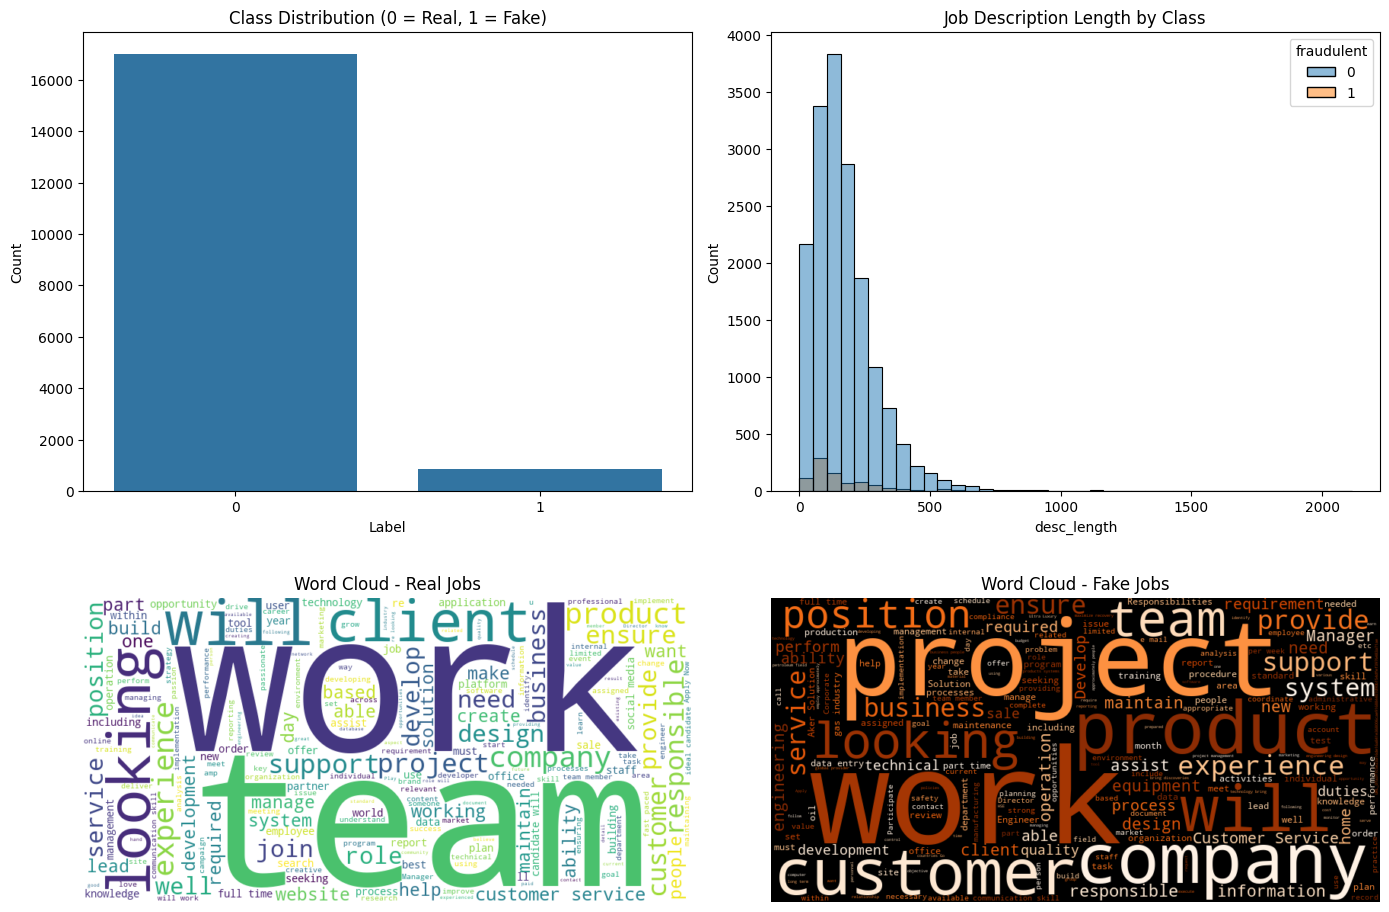

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Class distribution
class_counts = df_cleaned['fraudulent'].value_counts()

# Description length
df_cleaned['desc_length'] = df_cleaned['description'].fillna('').apply(lambda x: len(x.split()))

# Word clouds for real vs fake
real_desc = " ".join(df_cleaned[df_cleaned['fraudulent'] == 0]['description'].dropna().tolist())
fake_desc = " ".join(df_cleaned[df_cleaned['fraudulent'] == 1]['description'].dropna().tolist())

wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_desc)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Oranges').generate(fake_desc)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axs[0, 0])
axs[0, 0].set_title("Class Distribution (0 = Real, 1 = Fake)")
axs[0, 0].set_xlabel("Label")
axs[0, 0].set_ylabel("Count")

# Description length
sns.histplot(data=df_cleaned, x="desc_length", hue="fraudulent", bins=40, ax=axs[0, 1])
axs[0, 1].set_title("Job Description Length by Class")

# Real word cloud
axs[1, 0].imshow(wordcloud_real, interpolation='bilinear')
axs[1, 0].axis('off')
axs[1, 0].set_title("Word Cloud - Real Jobs")

# Fake word cloud
axs[1, 1].imshow(wordcloud_fake, interpolation='bilinear')
axs[1, 1].axis('off')
axs[1, 1].set_title("Word Cloud - Fake Jobs")

plt.tight_layout()
plt.show()

## Step 3: Text Preprocessing and Vectorization

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download needed NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Apply preprocessing to descriptions
df_cleaned['cleaned_desc'] = df_cleaned['description'].apply(preprocess_text)

# Show sample
df_cleaned[['description', 'cleaned_desc']].head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thiha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thiha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thiha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,description,cleaned_desc
0,"Food52, a fast-growing, James Beard Award-winn...",food fast growing james beard award winning on...
1,Organised - Focused - Vibrant - Awesome!Do you...,organised focused vibrant awesome passion cust...
2,"Our client, located in Houston, is actively se...",client located houston actively seeking experi...


## Step 4: Convert Text to TF-IDF Vectors

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df_cleaned['cleaned_desc'])

# Target variable
y = df_cleaned['fraudulent']

# Show shape
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (17880, 3000)


## Step 5: Train Supervised Text Classification Models

🔍 Logistic Regression
Accuracy: 0.9661633109619687
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3403
           1       0.98      0.31      0.47       173

    accuracy                           0.97      3576
   macro avg       0.97      0.65      0.72      3576
weighted avg       0.97      0.97      0.96      3576



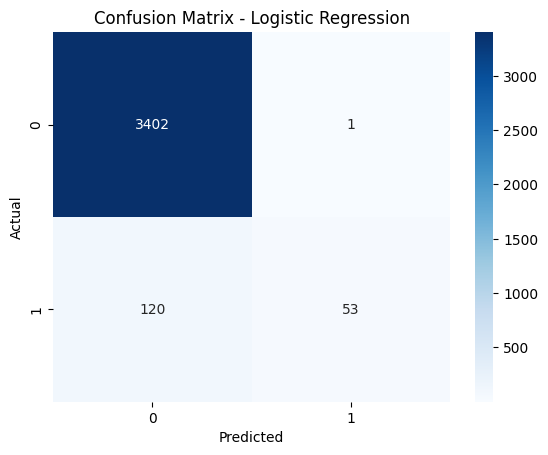

🔍 Naive Bayes
Accuracy: 0.9630872483221476
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.98      0.24      0.39       173

    accuracy                           0.96      3576
   macro avg       0.97      0.62      0.68      3576
weighted avg       0.96      0.96      0.95      3576



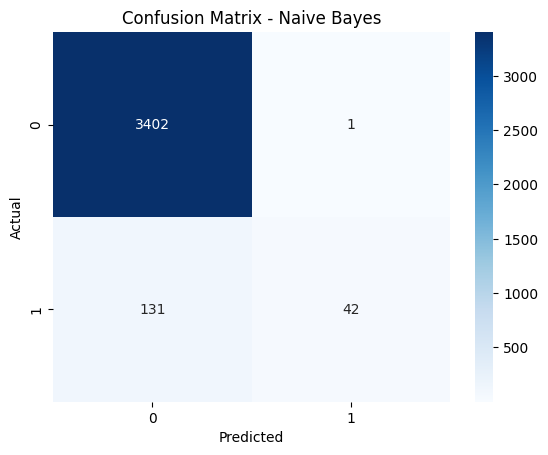

🔍 Random Forest
Accuracy: 0.9790268456375839
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.57      0.73       173

    accuracy                           0.98      3576
   macro avg       0.98      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576



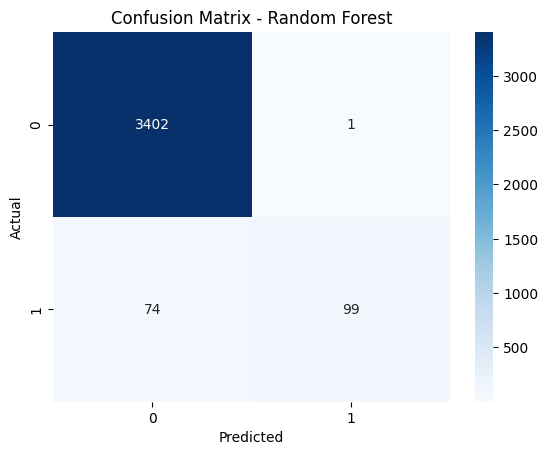

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train and evaluate
for name, model in models.items():
    print(f"🔍 {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## Step 6: Hyperparameter Tuning and Evaluation

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 🔧 Tune Logistic Regression
log_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_log = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5, scoring='f1', verbose=1)
grid_log.fit(X_train, y_train)

print("✅ Best Logistic Regression Params:", grid_log.best_params_)
print("F1-Score on Test Set:", f1_score(y_test, grid_log.predict(X_test)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
F1-Score on Test Set: 0.6928571428571428


In [8]:
# 🔧 Tune Random Forest
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1', verbose=1)
grid_rf.fit(X_train, y_train)

print("✅ Best Random Forest Params:", grid_rf.best_params_)
print("F1-Score on Test Set:", f1_score(y_test, grid_rf.predict(X_test)))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Random Forest Params: {'max_depth': None, 'n_estimators': 100}
F1-Score on Test Set: 0.7252747252747253


## Final Model Comparison

After tuning, compare F1-scores and choose the best model for deployment. Optionally, reference related studies or past research for benchmarking.

In [9]:
import joblib

# Save best model and vectorizer
joblib.dump(grid_log.best_estimator_, "best_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']